# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/EhWeqeQsh-9Mr1fneZc9_0sBOBzEdXngvxFJtAlIa-eAgA?e=8ukWwa). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

### BusinessProblem
n this scenario, the business goal I am trying to achieve is to help a travel booking website improve customer experience by predicting whether a flight
is likely to be delayed. By providing this information before customers book, the company can reduce inconvenience, increase trust, and help users 
make better travel decisions.
### BusinessGoal
he business goal is to build a predictive model that estimates the probability of flight delays based on historical data such as airline, origin, 
destination, distance, and time of day. The key business metric to evaluate success will be model accuracy and F1-score
aiming to correctly identify most delayed flights without too many false alarms.
### ML problem Statement
“Using historical flight and schedule data, predict whether a flight will be delayed by more than 15 minutes.”

This is a supervised machine learning classification problem because we already know the outcomes (delayed or on-time) from past data.
Machine learning is appropriate because flight delays are influenced by many variables (time, airline, airport traffic, weather), and ML models can 
learn complex patterns and relationships more effectively than manual rules or simple statistical approaches.
                                                                                     

### 2. Formulate the business problem, success metrics, and desired ML output.

# Write your answer here and turn the cell type into markdown
# Business Problem 
The business problem is to predict whether a scheduled flight will be delayed so that the travel booking website can proactively inform customers before they complete a booking. This will help reduce frustration, improve transparency, and enhance overall customer satisfaction.
The success metrics for this project include:
1. F1-Score – to balance precision (how many predicted delays are correct) and recall (how many actual delays are captured).
2. Accuracy – to measure overall correctness of predictions.
3. ROC-AUC – to evaluate how well the model distinguishes between delayed and on-time flights.
And from a business perspective, success can also be measured by a reduction in customer complaints and improved booking experience.

The desired machine learning output is a binary classification label (0 for on-time, 1 for delayed) along with a probability score indicating the likelihood of delay.
This output can be integrated into the booking system to alert users about potential delays, allowing them to make informed travel decisions or select alternative flights.


### 3. Identify the type of ML problem you’re dealing with.

The type of machine learning problem in this scenario is a supervised binary classification problem.
We have historical flight data with known outcomes — each record indicates whether the flight was delayed or not. The model will learn from these labeled examples to predict future outcomes.

The target variable is Delayed, which takes two possible values:

0: Flight arrived on time

1: Flight was delayed (arrival delay > 15 minutes)

Because the goal is to classify future flights into one of two categories based on multiple input features (time, airline, route, distance, etc.), supervised classification is the most appropriate approach.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [9]:
import os
from pathlib import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [16]:

# Relative paths
zip_path = Path("data")                 
base_path = Path(".")                   
csv_base_path = Path("data/extracted")  

csv_base_path.mkdir(parents=True, exist_ok=True)

# Count zip files
num_zip_files = len(glob.glob(str(zip_path / "*.zip")))
print(f"Number of ZIP files found: {num_zip_files}")


Number of ZIP files found: 2


# How many zip files do we have? write a code to answer it.
2

#### Extract CSV files from ZIP files

In [23]:
from zipfile import ZipFile
from pathlib import Path
import glob

zip_path = Path("data")             
csv_base_path = Path("data/extracted")
csv_base_path.mkdir(parents=True, exist_ok=True)


zip_files = glob.glob(str(zip_path / "*.zip"))
print(f"Found {len(zip_files)} zip files:", zip_files)


def zip2csv(zipFile_name, file_path):
    """
    Extract CSV from ZIP files.
    zipFile_name: name of the ZIP file
    file_path   : folder to store extracted CSVs
    """
    try:
        with ZipFile(zipFile_name, 'r') as z:
            print(f"Extracting {zipFile_name}...")
            z.extractall(path=file_path)
    except Exception as e:
        print(f"zip2csv failed for {zipFile_name}: {e}")


for file in zip_files:
    zip2csv(file, csv_base_path)

print("Files Extracted Successfully!")


Found 2 zip files: ['data\\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_9.zip', 'data\\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_6.zip']
Extracting data\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_9.zip...
Extracting data\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_6.zip...
Files Extracted Successfully!


In [25]:
# How many csv files have we extracted? write a code to answer it.
csv_files = glob.glob(str(Path(csv_base_path) / "*.csv"))
print(f"Number of CSV files extracted: {len(csv_files)}")


Number of CSV files extracted: 2


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [31]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}/readme.html"), width=1000, height=600)


#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [48]:
file_path = "data/extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_9.csv"

df_temp = pd.read_csv(file_path, low_memory=False)


**Question**: Print the row and column length in the dataset, and print the column names.

In [46]:
df_shape = df_temp.shape

print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (469489, 110)


**Question**: Print the first 10 rows of the dataset.  

In [50]:
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2014,3,9,8,1,2014-09-08,OO,20304,OO,N862AS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,3,9,2,2,2014-09-02,OO,20304,OO,N465SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,3,9,5,5,2014-09-05,OO,20304,OO,N466SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,3,9,1,1,2014-09-01,OO,20304,OO,N868CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,3,9,17,3,2014-09-17,OO,20304,OO,N863AS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014,3,9,16,2,2014-09-16,OO,20304,OO,N466SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014,3,9,13,6,2014-09-13,OO,20304,OO,N868CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014,3,9,5,5,2014-09-05,OO,20304,OO,N466SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014,3,9,20,6,2014-09-20,OO,20304,OO,N868CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014,3,9,11,4,2014-09-11,OO,20304,OO,N464SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [53]:
print(f'The column names are :')
print('#########')

for col in df_temp.columns:
    print(col)


The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [55]:
# Find all column names that contain the word 'Del'
delay_columns = [col for col in df_temp.columns if 'Del' in col]

print("Columns containing the word 'Del':")
print("#################################")
for col in delay_columns:
    print(col)


Columns containing the word 'Del':
#################################
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
DivArrDelay


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [59]:
print("The #rows and #columns are ", df_temp.shape[0], " and ", df_temp.shape[1])
print("The years in this dataset are: ", df_temp['Year'].unique())
print("The months covered in this dataset are: ", df_temp['Month'].unique())
print("The date range for data is :", df_temp['FlightDate'].min(), " to ", df_temp['FlightDate'].max())
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))


The #rows and #columns are  469489  and  110
The years in this dataset are:  [2014]
The months covered in this dataset are:  [9]
The date range for data is : 2014-09-01  to  2014-09-30
The airlines covered in this dataset are:  ['OO', 'UA', 'US', 'VX', 'WN', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'FL', 'HA', 'MQ']
The Origin airports covered are:  ['LAX', 'SLC', 'FAT', 'RNO', 'MRY', 'ELP', 'SEA', 'EWR', 'SJU', 'BOS', 'DFW', 'DEN', 'HNL', 'IAH', 'SAN', 'IAD', 'SAT', 'SNA', 'PIT', 'ORD', 'LAS', 'SFO', 'SMF', 'LGA', 'CLE', 'BOI', 'MCO', 'PHX', 'PHL', 'ATL', 'FLL', 'PDX', 'BWI', 'MSY', 'DCA', 'AUS', 'MIA', 'MDT', 'RDU', 'PBI', 'TPA', 'ANC', 'RSW', 'GEG', 'KOA', 'OGG', 'ALB', 'GUM', 'IND', 'OKC', 'BDL', 'CMH', 'JFK', 'OMA', 'GRR', 'SJC', 'BZN', 'PVD', 'JAC', 'LIH', 'MSP', 'ROC', 'DTW', 'CLT', 'STL', 'RIC', 'MCI', 'BUF', 'ICT', 'DSM', 'BIL', 'BQN', 'ITO', 'YUM', 'SBP', 'SBA', 'BFL', 'GJT', 'PSP', 'DRO', 'TUS', 'MSN', 'HLN', 'SBN', 'ISN', 'BNA', 'MKE', 'LAN', 'GFK', 'BIS', 'DLH', 'FAR', 'ABQ', '

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [61]:
counts = pd.DataFrame({
    'Origin': df_temp['Origin'].value_counts(),
    'Destination': df_temp['Dest'].value_counts()
})
counts


,Origin,Destination
ABE,173,173
ABI,232,232
ABQ,2022,2020
ABR,60,60
ABY,84,85
...,...,...
WRG,60,60
WYS,61,61
XNA,812,814
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [65]:
counts.sort_values(by='Origin', ascending=False).head(15)


,Origin,Destination
ATL,30196,30198
ORD,24870,24905
DFW,23025,23023
DEN,18935,18907
LAX,17589,17585
SFO,13878,13871
IAH,13496,13506
PHX,12126,12132
LAS,11231,11225
SEA,9316,9314


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Yes, based on all the information available in the dataset (such as flight date, airline, origin, destination, scheduled times, distance, and weather-related features), we can use machine learning to predict whether a flight will be delayed or not.


Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [74]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name=None, verbose=True):
    frames = []
    total_in = 0
    for fp in csv_files:
        try:
            part = pd.read_csv(fp, low_memory=False)
            n0 = len(part); total_in += n0
            if verbose: print(f"[READ] {fp} -> rows={n0}, cols={len(part.columns)}")

            # keep only requested columns that actually exist
            if filter_cols:
                keep = [c for c in filter_cols if c in part.columns]
                missing = [c for c in filter_cols if c not in part.columns]
                if verbose and missing:
                    print(f"  - missing columns (ignored): {missing}")
                part = part[keep]

            # apply row filters
            if subset_cols and subset_vals:
                for col, vals in zip(subset_cols, subset_vals):
                    if col in part.columns:
                        before = len(part)
                        part = part[part[col].isin(vals)]
                        if verbose:
                            print(f"  - filter {col} in {vals[:5]}... -> {before} -> {len(part)} rows")
                    else:
                        if verbose:
                            print(f"  - skip filter: column not found: {col}")

            frames.append(part)

        except Exception as e:
            print(f"[SKIP] {fp}: {e}")

    if not frames:
        print("No data combined (no readable files).")
        return pd.DataFrame()

    df = pd.concat(frames, ignore_index=True)
    if "FlightDate" in df.columns:
        df["FlightDate"] = pd.to_datetime(df["FlightDate"], errors="coerce")
        df = df.sort_values("FlightDate").reset_index(drop=True)

    if verbose:
        print(f"[COMBINED] rows={len(df)} (from {total_in} input rows) | cols={len(df.columns)}")

    if file_name:
        Path(file_name).parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(file_name, index=False)
        print(f"Saved combined file to: {file_name} (rows={len(df)})")

    return df


In [77]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [83]:
start = time.time()

combined_csv_filename = f"{base_path}/combined_files.csv"

# Call the combine_csv function
combined = combine_csv(
    csv_files=csv_files,
    filter_cols=cols,           # list of columns to keep
    subset_cols=subset_cols,    # ['Origin','Dest','Reporting_Airline']
    subset_vals=subset_vals,    # top airports & top airlines
    file_name=combined_csv_filename,
    verbose=True
)

print(f"Combined CSVs saved to: {combined_csv_filename}")
print(f" CSVs merged in {round((time.time() - start)/60, 2)} minutes")


[READ] data\extracted\On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_9.csv -> rows=469489, cols=110
  - filter Origin in ['ATL', 'ORD', 'DFW', 'DEN', 'CLT']... -> 469489 -> 163258 rows
  - filter Dest in ['ATL', 'ORD', 'DFW', 'DEN', 'CLT']... -> 163258 -> 32364 rows
  - filter Reporting_Airline in ['UA', 'OO', 'WN', 'AA', 'DL']... -> 32364 -> 23440 rows
[READ] data\extracted\On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv -> rows=494266, cols=110
  - filter Origin in ['ATL', 'ORD', 'DFW', 'DEN', 'CLT']... -> 494266 -> 159561 rows
  - filter Dest in ['ATL', 'ORD', 'DFW', 'DEN', 'CLT']... -> 159561 -> 33548 rows
  - filter Reporting_Airline in ['UA', 'OO', 'WN', 'AA', 'DL']... -> 33548 -> 30118 rows
[COMBINED] rows=53558 (from 963755 input rows) | cols=20
Saved combined file to: ./combined_files.csv (rows=53558)
Combined CSVs saved to: ./combined_files.csv
 CSVs merged in 0.26 minutes


#### Load dataset

Load the combined dataset.

In [85]:
data = pd.read_csv(f"{base_path}/combined_files.csv")


Print the first 5 records.

In [87]:
# Print the first 5 records from the combined dataset
data.head(5)


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,3,9,1,1,2014-09-01,AA,LAX,CA,DFW,TX,1155,0.0,0.0,1235.0,5,41.0,41.0,1.0,151.0
1,2014,3,9,1,1,2014-09-01,UA,IAH,TX,PHX,AZ,1420,0.0,0.0,1009.0,5,-16.0,0.0,0.0,133.0
2,2014,3,9,1,1,2014-09-01,UA,LAX,CA,SFO,CA,2245,0.0,0.0,337.0,2,-2.0,0.0,0.0,51.0
3,2014,3,9,1,1,2014-09-01,UA,IAH,TX,ORD,IL,1737,0.0,0.0,925.0,4,9.0,9.0,0.0,125.0
4,2014,3,9,1,1,2014-09-01,UA,IAH,TX,LAX,CA,1013,0.0,0.0,1379.0,6,-18.0,0.0,0.0,178.0


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [90]:
print("The #rows and #columns are ", data.shape[0], " and ", data.shape[1])
print("The years in this dataset are: ", list(data['Year'].unique()))
print("The months covered in this dataset are: ", sorted(list(data['Month'].unique())))
print("The date range for data is :", data['FlightDate'].min(), " to ", data['FlightDate'].max())
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))


The #rows and #columns are  53558  and  20
The years in this dataset are:  [2014, 2017]
The months covered in this dataset are:  [6, 9]
The date range for data is : 2014-09-01  to  2017-06-30
The airlines covered in this dataset are:  ['AA', 'UA', 'OO', 'DL', 'WN']
The Origin airports covered are:  ['LAX', 'IAH', 'PHX', 'DEN', 'ORD', 'DFW', 'ATL', 'SFO', 'CLT']
The Destination airports covered are:  ['DFW', 'PHX', 'SFO', 'ORD', 'LAX', 'IAH', 'CLT', 'DEN', 'ATL']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [93]:
data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True)


Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [96]:

null_counts = data.isnull().sum(axis=0)
print("Number of null values in each column:\n")
print(null_counts[null_counts > 0])


Number of null values in each column:

ArrDelay           669
ArrDelayMinutes    669
is_delay           669
AirTime            669
dtype: int64


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [99]:

data = data[~data['ArrDelay'].isnull() & ~data['AirTime'].isnull()]


Get the hour of the day in 24-hour time format from CRSDepTime.

In [102]:

data['DepHourofDay'] = (data['CRSDepTime'] // 100).astype(int)

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

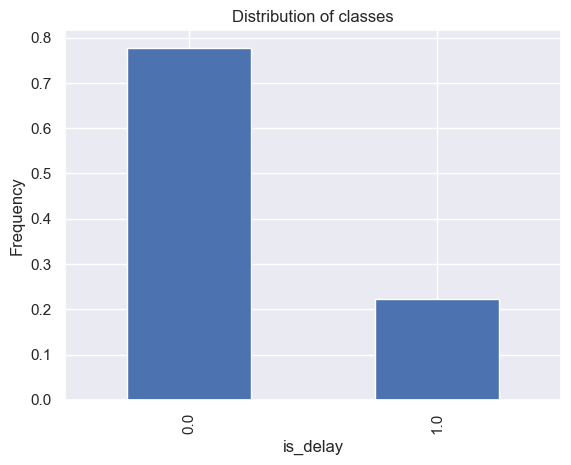

In [106]:
(data.groupby('is_delay').size() / len(data)).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()


**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

From the bar plot, we can see that the majority of flights are on time (label 0), while only a smaller proportion are delayed (label 1).
Approximately 77–78% of flights are on time, and around 22–23% experience delays of more than 15 minutes.

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

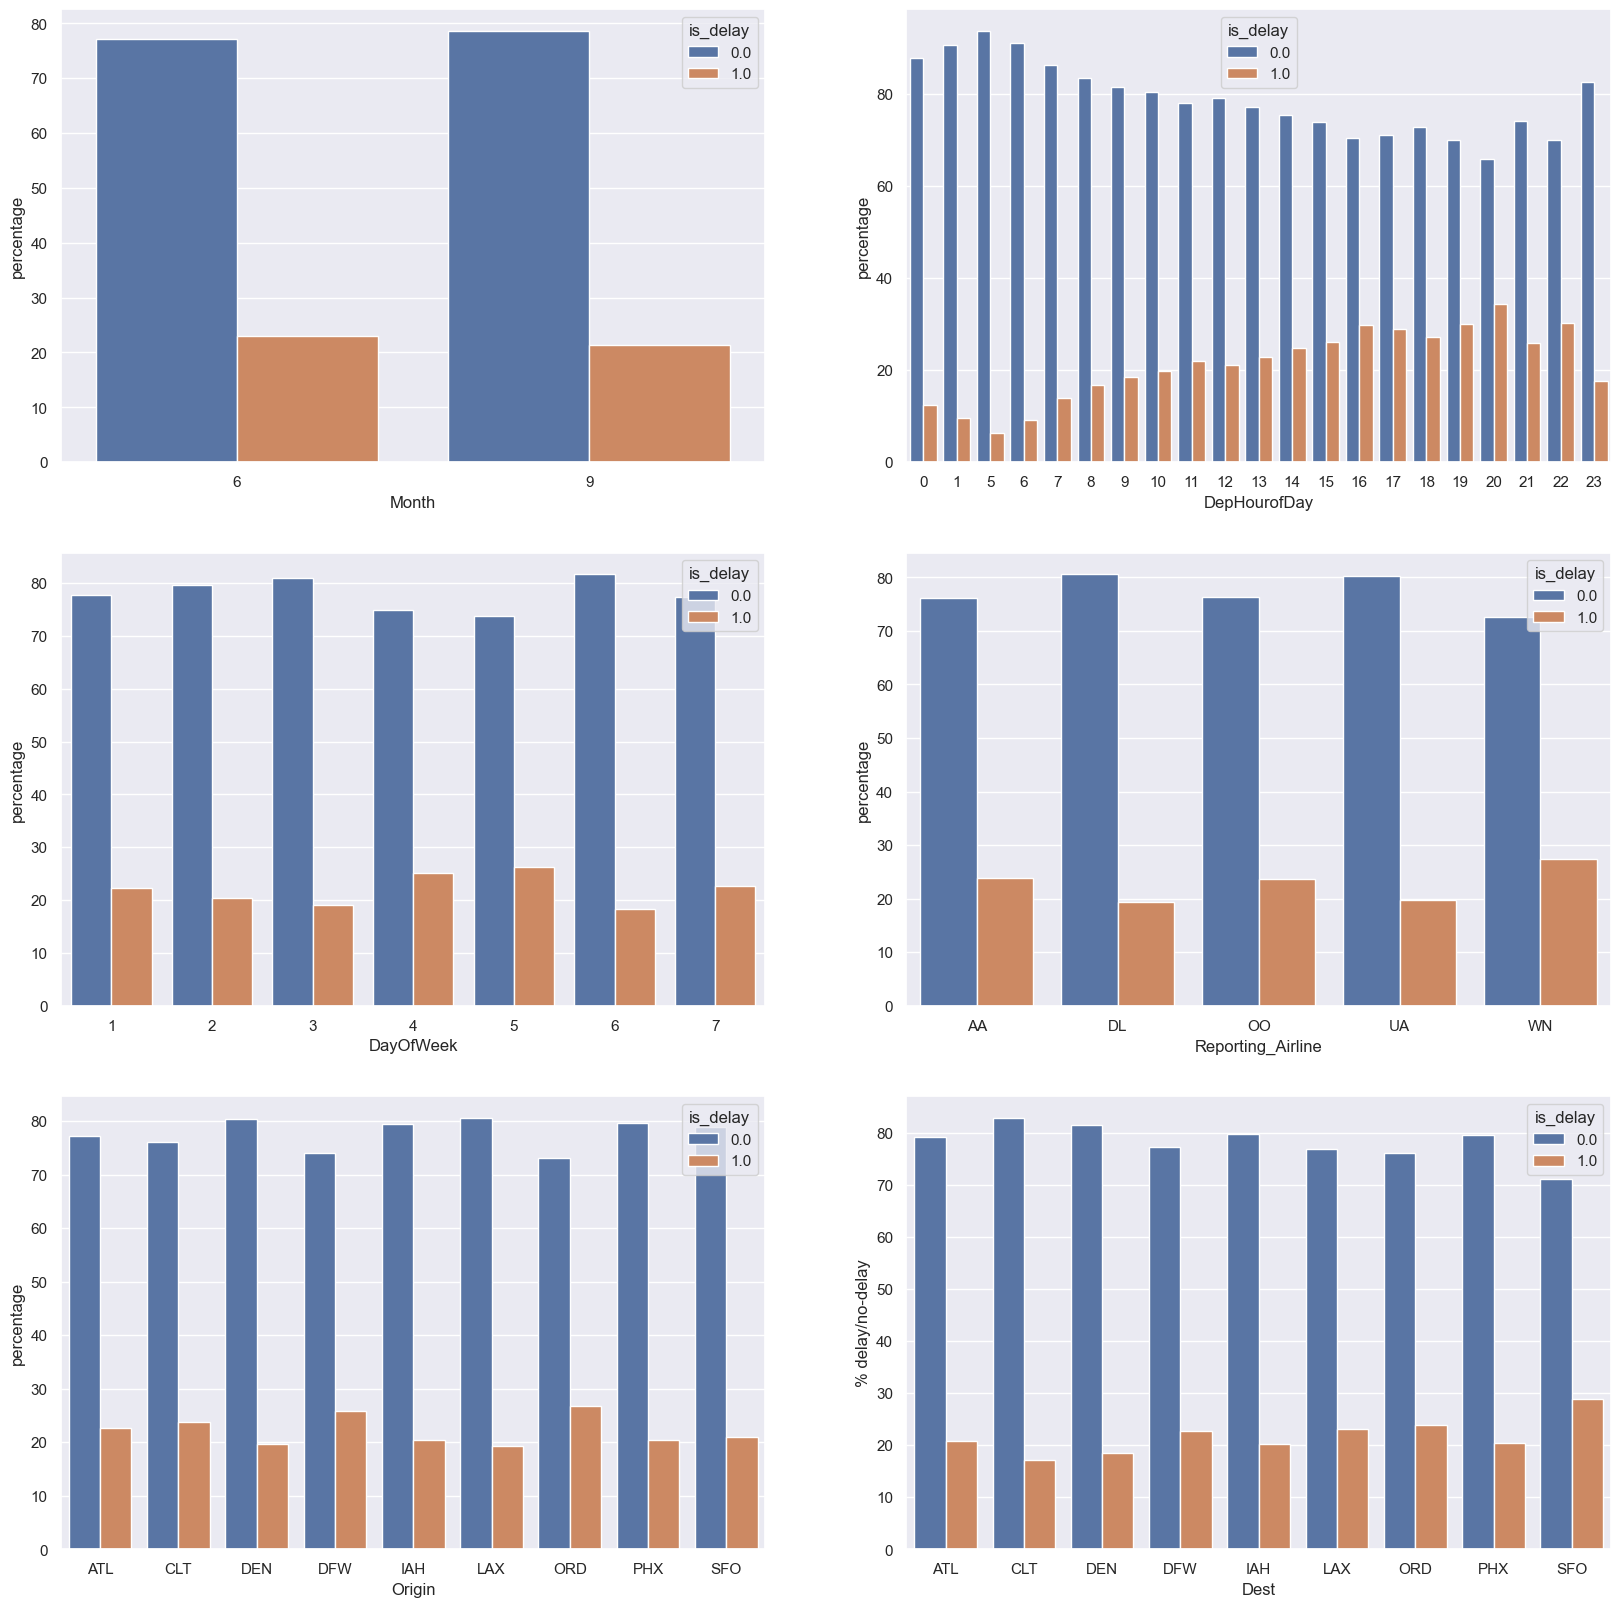

In [109]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

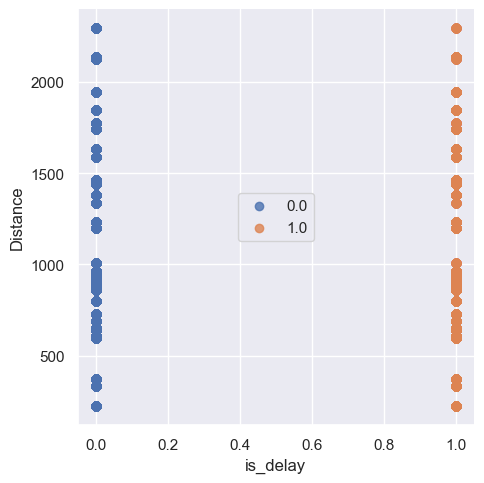

In [111]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

1. Which months have the most delays?
The months June and September show similar delay ratios, meaning flight delays occur fairly consistently across these months, with no major seasonal spike in this sample.

2. What time of the day has the most delays?
Delays are less frequent during early morning (0–8 hrs) but increase during afternoon and evening hours (12–21 hrs), peaking around 8 PM (20 hrs). This pattern suggests cumulative congestion and scheduling delays later in the day.

3. What day of the week has the most delays?
Delays are relatively consistent across the week, though Thursdays and Fridays (Day 4–5) show slightly higher delay percentages, likely due to increased travel demand near weekends.

4. Which airline has the most delays?
Among the top airlines, Southwest (WN) and American Airlines (AA) show slightly higher proportions of delays compared to Delta (DL) and United (UA), which maintain better on-time performance.

5. Which origin and destination airports have the most delays?
Flights from and to Chicago O’Hare (ORD) and Dallas/Fort Worth (DFW) experience slightly higher delay percentages compared to other airports. These are large, busy hubs where traffic volume and weather may contribute to delays.

6. Is flight distance a factor in the delays?
The scatter plot shows no strong correlation between flight distance and delays both short and long flights experience similar delay ratios. So the distance is not a major determinant of flight delays in this dataset.

### Features

Look at all the columns and what their specific types are.

In [113]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [115]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int32
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [118]:
data_orig = data.copy()


data = data[['is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
             'Reporting_Airline', 'Origin', 'Dest', 'Distance', 'DepHourofDay']].copy()

categorical_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
                       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']

for c in categorical_columns:
    data.loc[:, c] = data[c].astype('category')


To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [121]:

data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data = pd.concat([data, data_dummies], axis=1)
data.drop(categorical_columns, axis=1, inplace=True)


Check the length of the dataset and the new columnms.

In [123]:
print("Number of rows:", len(data))

Number of rows: 52889


In [125]:
print("Number of columns:", data.shape[1])

Number of columns: 22


**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [128]:
data.rename(columns={'is_delay': 'target'}, inplace=True)


In [130]:
# Save the processed combined dataset to a CSV file for use in Part B (on-cloud)
data.to_csv("combined_csv_v1.csv", index=False)

print("Combined CSV file saved successfully as 'combined_csv_v1.csv'")


Combined CSV file saved successfully as 'combined_csv_v1.csv'


# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [136]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target']

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(" Data successfully split!")
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


 Data successfully split!
Training set size: (42311, 21)
Testing set size: (10578, 21)


### Baseline classification model

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Baseline Logistic Regression Model Results\n")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Baseline Logistic Regression Model Results

Accuracy: 0.7775

Confusion Matrix:
 [[8224    0]
 [2354    0]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      1.00      0.87      8224
         1.0       0.00      0.00      0.00      2354

    accuracy                           0.78     10578
   macro avg       0.39      0.50      0.44     10578
weighted avg       0.60      0.78      0.68     10578



## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Delay (0)', 'Delay (1)'],
                yticklabels=['No Delay (0)', 'Delay (1)'])
    
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [149]:
import matplotlib.pyplot as plt

def plot_roc(test_labels, target_predicted):

    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    auc_score = metrics.roc_auc_score(test_labels, target_predicted)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

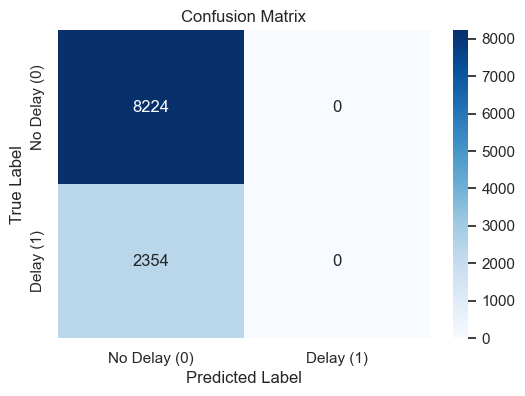

In [151]:
plot_confusion_matrix(y_test, y_pred)


To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

 Model Evaluation Metrics

Accuracy: 0.7775
Precision: 0.0
Recall (Sensitivity): 0.0
Specificity: 1.0
F1 Score: 0.0
AUC (ROC): 0.5968


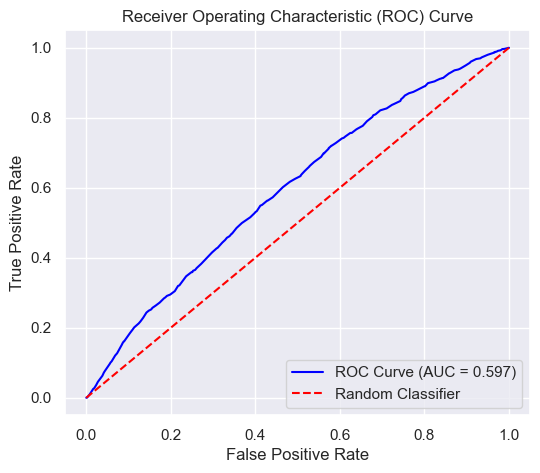

In [161]:
from sklearn import metrics

y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

print(" Model Evaluation Metrics\n")
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 4))
print("Precision:", round(metrics.precision_score(y_test, y_pred, zero_division=0), 4))
print("Recall (Sensitivity):", round(metrics.recall_score(y_test, y_pred, zero_division=0), 4))
print("Specificity:", round(
    metrics.recall_score(y_test, y_pred, pos_label=0, zero_division=0), 4))
print("F1 Score:", round(metrics.f1_score(y_test, y_pred, zero_division=0), 4))
print("AUC (ROC):", round(metrics.roc_auc_score(y_test, y_pred_prob), 4))

plot_roc(y_test, y_pred_prob)


### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


1. The model performs similarly on both the training and test datasets, achieving around 77.75%accuracy.
This accuracy is misleading because the model predicts every flight as “No Delay.”
This indicates over-reliance on the majority class due to severe class imbalance (about 77% on-time flights vs 23% delayed).
Although the performance seems stable, the model has no predictive power for delay detection.

2. Accuracy (0.78) appears high but only reflects the dominance of “No Delay” flights. Precision (0.00) and Recall (0.00) for the delay class show the model completely fails to identify delayed flights.
The imbalance means that a model can appear “accurate” while performing poorly on the minority (delay) class. This highlights why accuracy alone is not a reliable performance metric in imbalanced classification problems.

3. From a business standpoint, the model is not acceptable it fails to identify potential delays, which are crucial for airlines to manage crew schedules, passenger connections, and customer satisfaction.

4. Next steps for improvement:

a. Apply class balancing methods.
b.Add more informative features.
c.Experiment with nonlinear models (Random Forest, XGBoost) that handle complex feature interactions better.
d.Focus on improving Recall and F1-score for the delayed class rather than overall accuracy.

5. From the confusion matrix, we can see that the model correctly predicts all “No Delay” flights (8224), but it fails to identify any delayed flights (0 true positives) every delayed flight was misclassified as “No Delay.”

This means the model is completely biased toward the majority class (No Delay).

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitHub repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitHub account, and ensure it is public.


In [ ]:
### Provide a link for your GitHub repository here

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [ ]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = # Enter your code here 

Weather data was fetched from [this link](https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31).
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [15]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [ ]:
weather = pd.read_csv(<CODE>) # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = # Enter your code here 
weather['airport'] = # Enter your code here 

Create another column called `MONTH` from the `DATE` column.

In [ ]:
weather['MONTH'] = weather[<CODE>].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [ ]:
weather.SNOW.fillna(<CODE>, inplace=True)# Enter your code here
weather.SNWD.fillna(<CODE>, inplace=True)# Enter your code here
weather.isna().sum()

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [ ]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = # Enter your code here 
TMAX_idx = # Enter your code here 
TMIN_idx = # Enter your code here 
TAVG_idx

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [ ]:
weather_impute = weather.groupby([<CODE>]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

Merge the mean data with the weather data.

In [ ]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [ ]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [ ]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [ ]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [ ]:
sum(data.isna().any())

In [ ]:
data_orig.columns

Convert the categorical data into numerical data using one-hot encoding.

In [ ]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [ ]:
data_dummies = # Enter your code here

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [ ]:
data.columns

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [ ]:
data.rename(columns = {<CODE>:<CODE>}, inplace=True )# Enter your code here

In [16]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B

Create the training and testing sets again.

In [ ]:
# Enter your code here

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [ ]:
# Instantiate another logistic regression model
classifier2 = # Enter your code here

In [ ]:
# Enter your code here

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

In [17]:
# Enter answer here and turn the cell type into markdown


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

In [19]:
# copy the link here

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

In [18]:
# write your answers here